In [2]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Check if TensorFlow is using a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess/code

In [3]:
# Data processing functions
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    # Updated to match the newer librosa version
    rms = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rms)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result, zcr(data, frame_length, hop_length), rmse(data, frame_length, hop_length), mfcc(data, sr, frame_length, hop_length)))
    return result

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data)
    audio = np.array(aud)
    
    noised_audio = noise(data)
    aud2 = extract_features(noised_audio)
    audio = np.vstack((audio, aud2))
    
    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio)
    audio = np.vstack((audio, aud3))
    
    pitched_noised_audio = noise(pitch(data, sr))
    aud4 = extract_features(pitched_noised_audio)
    audio = np.vstack((audio, aud4))
    
    return audio

In [ ]:
Tess = "/Users/arek/Documents/assa/datasets/kaggle_speech_emotion/TESS Toronto emotional speech set data/"

def process_datasets():
    
    # Process TESS dataset
    tess_directory_list = os.listdir(Tess)
    file_emotion = []
    file_path = []
    for dir in tess_directory_list:
        # Skip files, only process directories
        dir_path = os.path.join(Tess, dir)
        if not os.path.isdir(dir_path):
            continue
        # Skip nested TESS directory
        if 'TESS Toronto' in dir:
            continue
            
        # List files in the emotion directory
        for file in os.listdir(dir_path):
            if not file.endswith('.wav'):
                continue
            # File format: OAF_word_emotion.wav or YAF_word_emotion.wav
            parts = file.split('.')[0].split('_')
            if len(parts) >= 3:
                emotion_part = parts[2]
                if emotion_part == 'ps':
                    file_emotion.append('surprise')
                else:
                    file_emotion.append(emotion_part)
                file_path.append(os.path.join(dir_path, file))
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    tess_df = pd.concat([emotion_df, path_df], axis=1)

    return tess_df

# Loading and preprocessing

In [91]:
data_path = process_datasets()

In [92]:
# Verify the loaded data
print(f"Total samples: {len(data_path)}")
print(f"\nEmotion distribution:")
print(data_path['Emotions'].value_counts())
print(f"\nFirst few rows:")
data_path.head()

Total samples: 2800

Emotion distribution:
Emotions
disgust     400
surprise    400
happy       400
sad         400
neutral     400
fear        400
angry       400
Name: count, dtype: int64

First few rows:


,Emotions,Path
0,disgust,/Users/arek/Documents/assa/datasets/kaggle_spe...
1,disgust,/Users/arek/Documents/assa/datasets/kaggle_spe...
2,disgust,/Users/arek/Documents/assa/datasets/kaggle_spe...
3,disgust,/Users/arek/Documents/assa/datasets/kaggle_spe...
4,disgust,/Users/arek/Documents/assa/datasets/kaggle_spe...


In [181]:
# tqdm 
from tqdm import tqdm

# Extract features and labels
X, Y = [], []
for path, emotion in tqdm(zip(data_path['Path'], data_path['Emotions']), total=len(data_path)):
    features = get_features(path)
    for i in features:
        X.append(i)
        Y.append(emotion)

100%|██████████| 2800/2800 [01:44<00:00, 26.91it/s]


In [182]:
len(X), len(Y), data_path.Path.shape

(11200, 11200, (2800,))

In [183]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2257,2258,2259,2260,2261,2262,2263,2264,2265,Emotions
0,0.012695,0.018555,0.027344,0.040527,0.047363,0.050293,0.046387,0.031738,0.023438,0.017578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
1,0.042480,0.076660,0.103027,0.108887,0.103027,0.094727,0.113770,0.165527,0.220703,0.294434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
2,0.013184,0.022949,0.055664,0.071289,0.077148,0.076172,0.057129,0.041016,0.039062,0.042969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
3,0.031738,0.053711,0.088867,0.099609,0.096680,0.087402,0.101074,0.134766,0.175781,0.249023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
4,0.041992,0.058594,0.067383,0.047852,0.037109,0.030273,0.032715,0.036621,0.040527,0.037109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust


In [184]:
Emotions = pd.read_csv('emotion.csv')
Emotions['Emotions'].value_counts()

Emotions
disgust     1600
surprise    1600
happy       1600
sad         1600
neutral     1600
fear        1600
angry       1600
Name: count, dtype: int64

In [185]:
# n = 12  # ile chcesz z każdej klasy
# Emotions = (
#     Emotions.groupby('Emotions', group_keys=False)
#       .apply(lambda x: x.sample(n=min(len(x), n), random_state=42))
# )
 
# print(Emotions['Emotions'].value_counts())  # sprawdź rozkład klas
# Emotions.reset_index(drop=True, inplace=True)

In [186]:
Emotions.isna().sum(axis=0).any()

np.True_

In [187]:
Emotions=Emotions.fillna(0)
# print(Emotions.isna().any())
# Emotions.shape

In [188]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [189]:
# One-hot encode the labels
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

In [190]:
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)



In [191]:
x_test.shape, y_test.shape

((2240, 2266), (2240, 7))

In [192]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_val = scaler.transform(x_test)

# Clustering

In [193]:
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning, PCA

# Section 4: Dictionary Learning (students tune hyperparameters)
N_COMPONENTS = 128
ALPHA = 1.0
MAX_ITER = 100

learner = DictionaryLearning(
    n_components=N_COMPONENTS,
    alpha=ALPHA,
    max_iter=MAX_ITER,
    fit_algorithm='cd',
    transform_algorithm='lasso_lars',
    transform_alpha=ALPHA,
    random_state=42,
    verbose=True
)

D_codes = learner.fit_transform(X_train)


[dict_learning] ....................................................................................................

In [194]:
D_atoms = learner.components_
print("Atoms:", D_atoms.shape)

Atoms: (128, 2266)


In [195]:
# Check D_atoms shape to determine correct PATCH_SIZE
print(f"D_atoms shape: {D_atoms.shape}")
print(f"Number of atoms: {D_atoms.shape[0]}")
print(f"Features per atom: {D_atoms.shape[1]}")

# For visualization, we need to reshape each atom (1D vector of size 2266)
# We can use various rectangular shapes that multiply to 2266
# Let's find factors of 2266
n_features = D_atoms.shape[1]
print(f"\nFactors of {n_features}:")
for i in range(1, int(np.sqrt(n_features)) + 1):
    if n_features % i == 0:
        print(f"  {i} × {n_features // i}")

D_atoms shape: (128, 2266)
Number of atoms: 128
Features per atom: 2266

Factors of 2266:
  1 × 2266
  2 × 1133
  11 × 206
  22 × 103


In [196]:
# Section 5: Reconstruction
C_val = learner.transform(X_val)
X_val_rec = C_val @ learner.components_
X_val_rec = scaler.inverse_transform(X_val_rec)
X_val_unscaled = scaler.inverse_transform(X_val)

mse = np.mean((X_val_unscaled - X_val_rec)**2)
print(f"Reconstruction MSE: {mse:.4e}")

Reconstruction MSE: 2.4554e+02


In [197]:
D_codes = learner.transform(X_train)
D_codes.shape

(8960, 128)

D_codes shape: (8960, 128)
Number of atoms (potential clusters): 128

DICTIONARY LEARNING CLUSTERING EVALUATION
Method: Assigning samples to most active dictionary atom
Number of unique clusters assigned: 7

Adjusted Rand Index (ARI): 0.2226
Normalized Mutual Information (NMI): 0.3194
Homogeneity: 0.3083
Completeness: 0.3314
V-measure: 0.3194

Interpretation:
- ARI: [-1, 1], higher is better, 1 = perfect clustering
- NMI: [0, 1], higher is better, 1 = perfect clustering
- Homogeneity: [0, 1], clusters contain only single class
- Completeness: [0, 1], all members of class in same cluster
- V-measure: [0, 1], harmonic mean of homogeneity & completeness


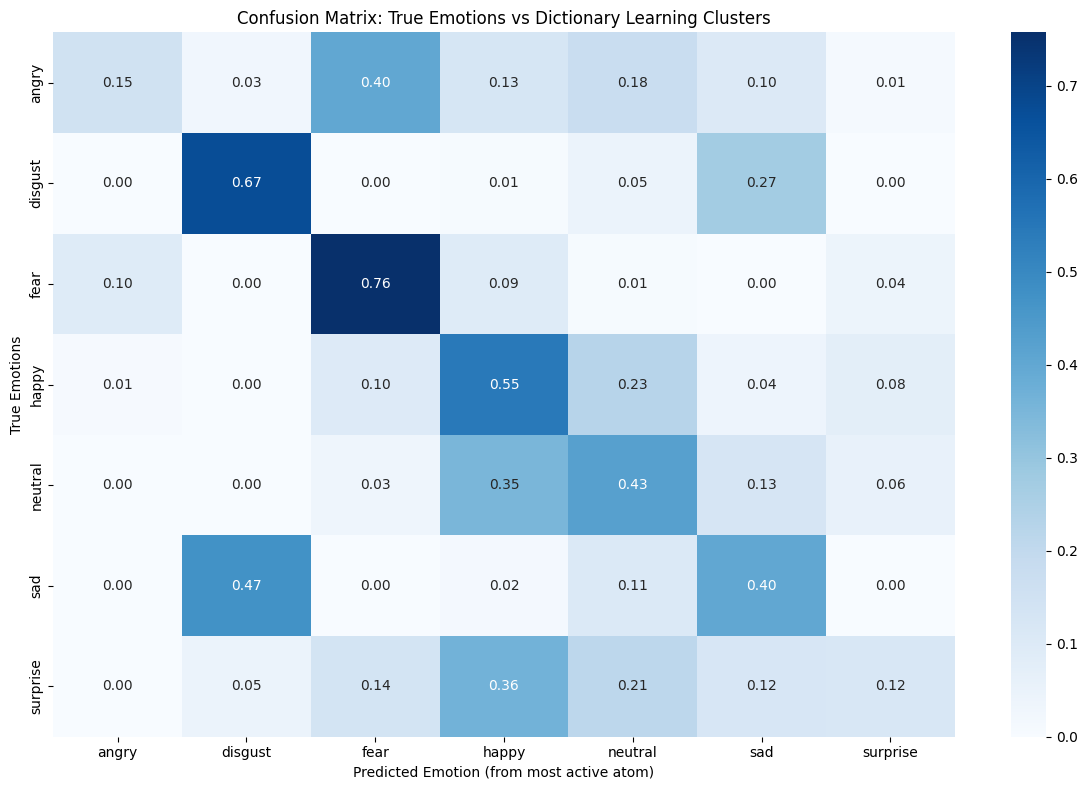


Remapped cluster distribution:
angry: 329 samples
disgust: 1560 samples
fear: 1837 samples
happy: 1926 samples
neutral: 1534 samples
sad: 1372 samples
surprise: 402 samples

True emotion distribution:
angry: 1263 samples
disgust: 1259 samples
fear: 1295 samples
happy: 1282 samples
neutral: 1263 samples
sad: 1304 samples
surprise: 1294 samples

Sparsity of dictionary codes: 83.97%
Average number of active atoms per sample: 20.5


In [198]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Use the dictionary learning sparse codes directly for clustering
# Each sample is represented by its sparse code (coefficients over the dictionary atoms)
# We assign each sample to the cluster corresponding to its most active atom
print(f"D_codes shape: {D_codes.shape}")
print(f"Number of atoms (potential clusters): {D_codes.shape[1]}")

# For each sample, find the atom with the highest coefficient (most active)
cluster_labels = np.argmax(np.abs(D_codes), axis=1)

# Get true labels for training data
y_train_true = np.argmax(y_train, axis=1)
emotion_names = encoder.categories_[0]

# Map clusters to emotions by finding the most common emotion in each cluster
# This helps with interpretation
cluster_to_emotion_mapping = {}
for cluster_id in range(N_COMPONENTS):
    mask = cluster_labels == cluster_id
    if np.sum(mask) > 0:
        emotions_in_cluster = y_train_true[mask]
        most_common_emotion = np.bincount(emotions_in_cluster).argmax()
        cluster_to_emotion_mapping[cluster_id] = most_common_emotion

# Remap cluster labels to match the number of emotions
# Group atoms that predominantly represent the same emotion
remapped_labels = np.array([cluster_to_emotion_mapping.get(c, 0) for c in cluster_labels])

# Calculate clustering evaluation metrics using the remapped labels
ari = adjusted_rand_score(y_train_true, remapped_labels)
nmi = normalized_mutual_info_score(y_train_true, remapped_labels)
homogeneity = homogeneity_score(y_train_true, remapped_labels)
completeness = completeness_score(y_train_true, remapped_labels)
v_measure = v_measure_score(y_train_true, remapped_labels)

print("\n" + "="*60)
print("DICTIONARY LEARNING CLUSTERING EVALUATION")
print("="*60)
print(f"Method: Assigning samples to most active dictionary atom")
print(f"Number of unique clusters assigned: {len(np.unique(remapped_labels))}")
print(f"\nAdjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-measure: {v_measure:.4f}")
print("\nInterpretation:")
print("- ARI: [-1, 1], higher is better, 1 = perfect clustering")
print("- NMI: [0, 1], higher is better, 1 = perfect clustering") 
print("- Homogeneity: [0, 1], clusters contain only single class")
print("- Completeness: [0, 1], all members of class in same cluster")
print("- V-measure: [0, 1], harmonic mean of homogeneity & completeness")

# Create confusion matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_train_true, remapped_labels, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=emotion_names,
            yticklabels=emotion_names)
plt.title('Confusion Matrix: True Emotions vs Dictionary Learning Clusters')
plt.xlabel('Predicted Emotion (from most active atom)')
plt.ylabel('True Emotions')
plt.tight_layout()
plt.show()

# Show cluster distribution
print(f"\nRemapped cluster distribution:")
unique_clusters, cluster_counts = np.unique(remapped_labels, return_counts=True)
for emotion_id, count in zip(unique_clusters, cluster_counts):
    print(f"{emotion_names[emotion_id]}: {count} samples")

print(f"\nTrue emotion distribution:")
unique_emotions, emotion_counts = np.unique(y_train_true, return_counts=True)
for emotion_id, count in zip(unique_emotions, emotion_counts):
    print(f"{emotion_names[emotion_id]}: {count} samples")

# Additional analysis: sparsity of the codes
sparsity = np.mean(np.abs(D_codes) < 1e-10)
print(f"\nSparsity of dictionary codes: {sparsity:.2%}")
print(f"Average number of active atoms per sample: {np.mean(np.sum(np.abs(D_codes) > 1e-10, axis=1)):.1f}")


In [177]:
y_train.sum(axis=0)

array([ 9.,  9., 10., 10.,  9., 10., 10.])

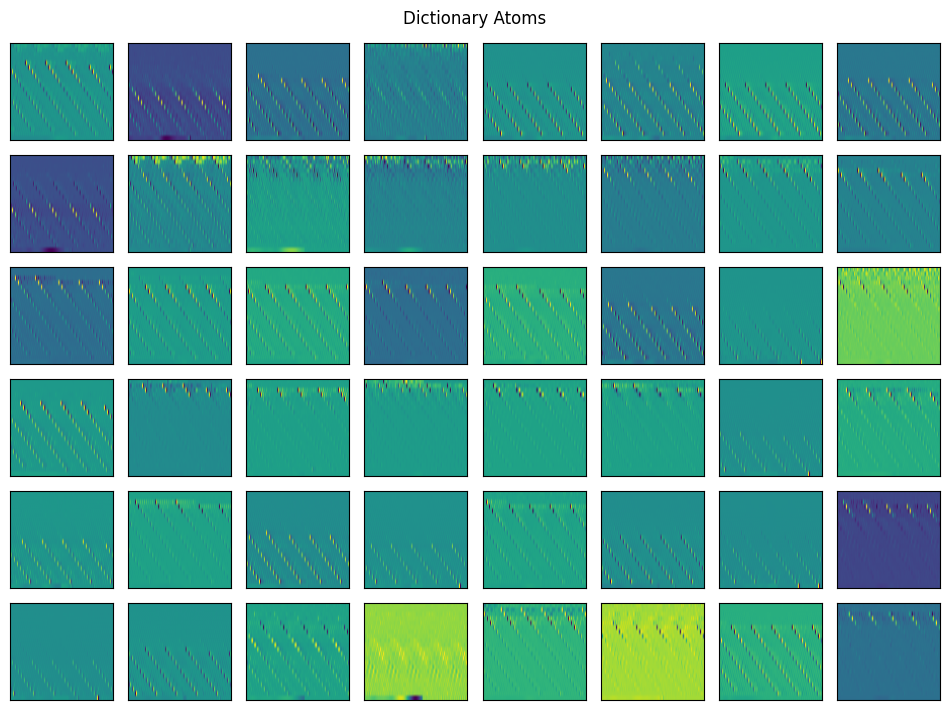

In [55]:
# D_atoms shape is (128, 2266) - 128 atoms with 2266 features each
# Valid factors of 2266: 1×2266, 2×1133, 11×206, 22×103
# Using 22×103 for better aspect ratio
PATCH_SIZE = (22, 103)

# Section 6: Visualization
def show_atoms(atoms, patch_size, n_rows=6, n_cols=8, title="Dictionary Atoms"):
    Ps, Pt = patch_size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(1.2*n_cols, 1.2*n_rows))
    for i, ax in enumerate(axes.flat):
        if i >= atoms.shape[0]:
            ax.axis('off'); continue
        im = ax.imshow(atoms[i].reshape(Ps, Pt), aspect='auto', origin='lower', cmap='viridis')
        ax.set_xticks([]); ax.set_yticks([])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_atoms(D_atoms, PATCH_SIZE)

# PCA Visualization - 2D Reduction

Original shape: (8960, 2266)
PCA shape: (8960, 2)
Explained variance ratio: [0.05464643 0.05353422]
Total explained variance: 0.1082


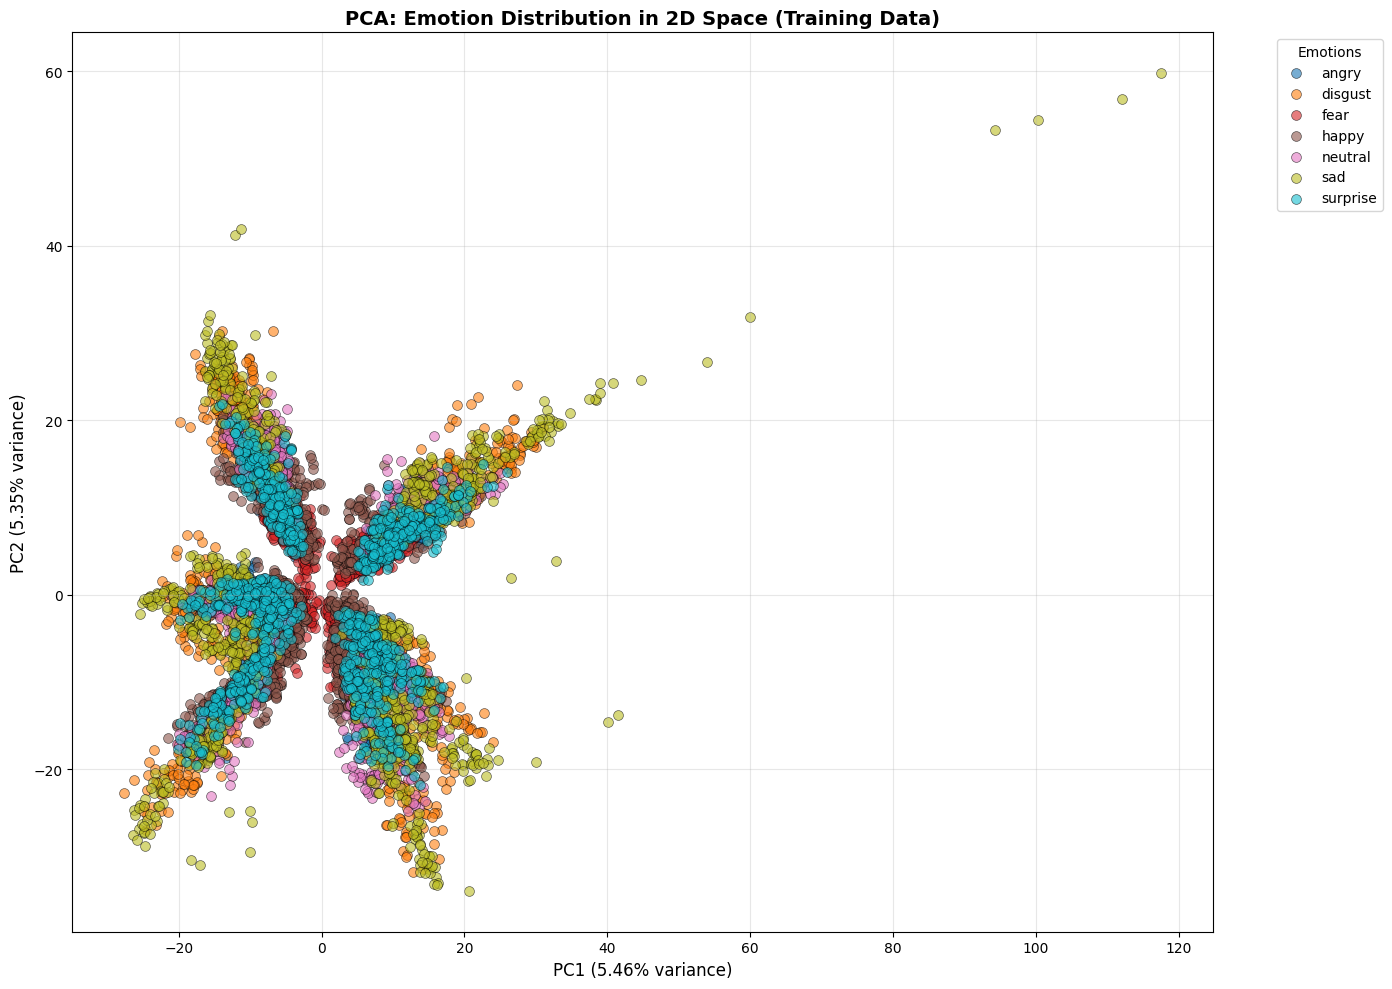

In [57]:
# Reduce to 2 components using PCA for visualization
from sklearn.decomposition import PCA

# Apply PCA to training data
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

print(f"Original shape: {X_train.shape}")
print(f"PCA shape: {X_train_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Get emotion labels for training data
y_train_labels = np.argmax(y_train, axis=1)
emotion_names = encoder.categories_[0]

# Create scatter plot
plt.figure(figsize=(14, 10))

# Define colors for each emotion
colors = plt.cm.tab10(np.linspace(0, 1, len(emotion_names)))

for i, emotion in enumerate(emotion_names):
    mask = y_train_labels == i
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                c=[colors[i]], label=emotion, alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('PCA: Emotion Distribution in 2D Space (Training Data)', fontsize=14, fontweight='bold')
plt.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

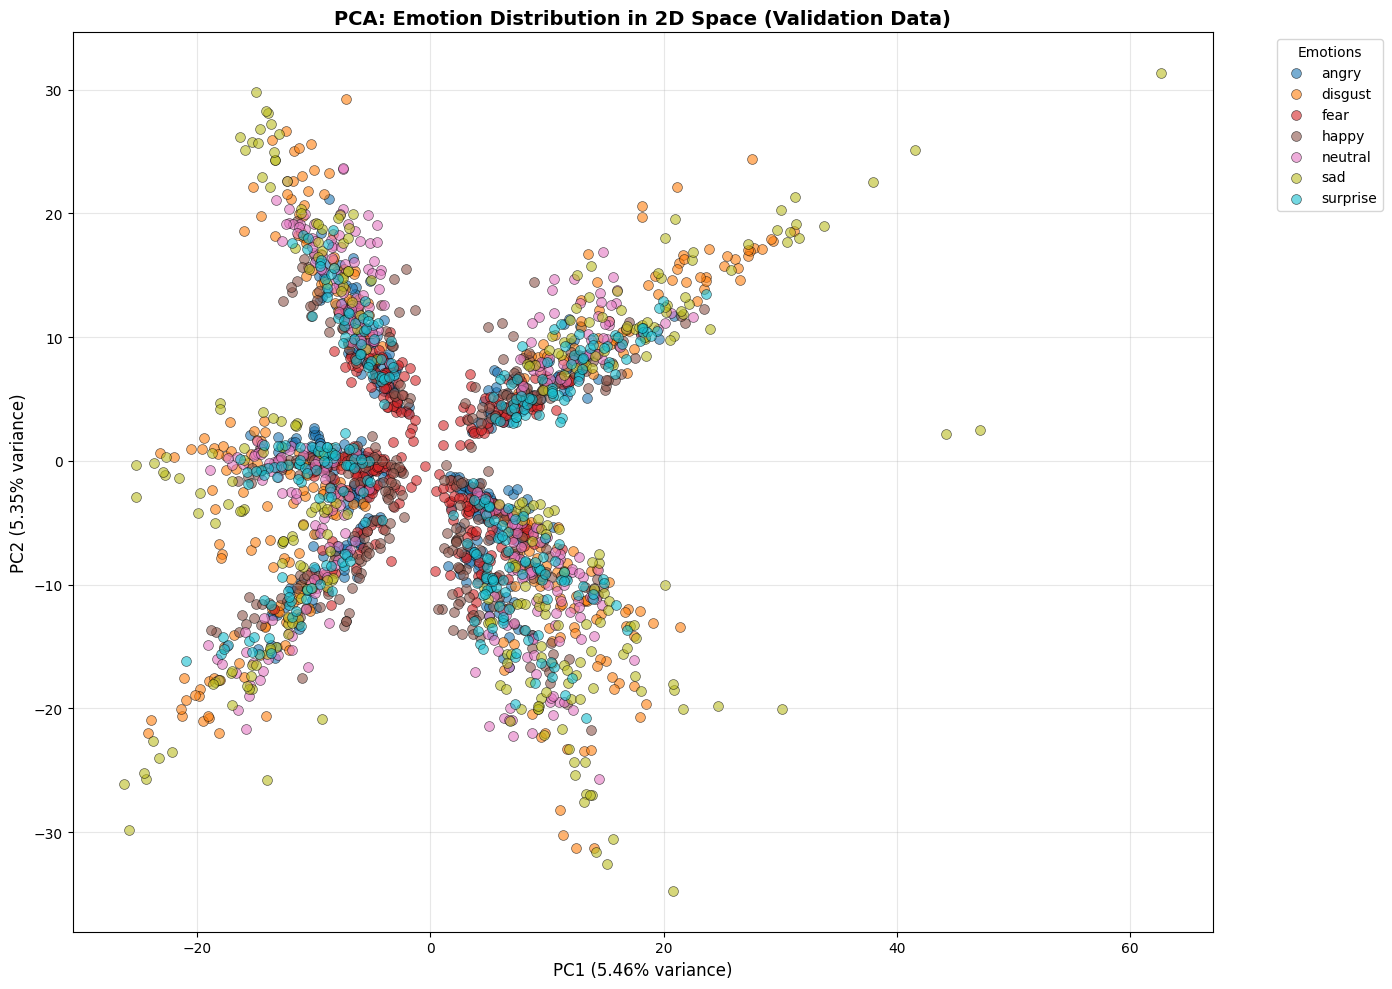

In [58]:
# Also show validation data
y_val_labels = np.argmax(y_test, axis=1)

plt.figure(figsize=(14, 10))

for i, emotion in enumerate(emotion_names):
    mask = y_val_labels == i
    plt.scatter(X_val_pca[mask, 0], X_val_pca[mask, 1], 
                c=[colors[i]], label=emotion, alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('PCA: Emotion Distribution in 2D Space (Validation Data)', fontsize=14, fontweight='bold')
plt.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# t-SNE Visualization - 2D Reduction

t-SNE (t-Distributed Stochastic Neighbor Embedding) is often better than PCA for visualizing high-dimensional data, as it preserves local structure better.

Running t-SNE on training data (this may take a few minutes)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.004s...
[t-SNE] Computed neighbors for 5000 samples in 1.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 11.575457
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.514450
[t-SNE] KL divergence after 1000 iterations: 0.570431

t-SNE completed in 26.51 seconds


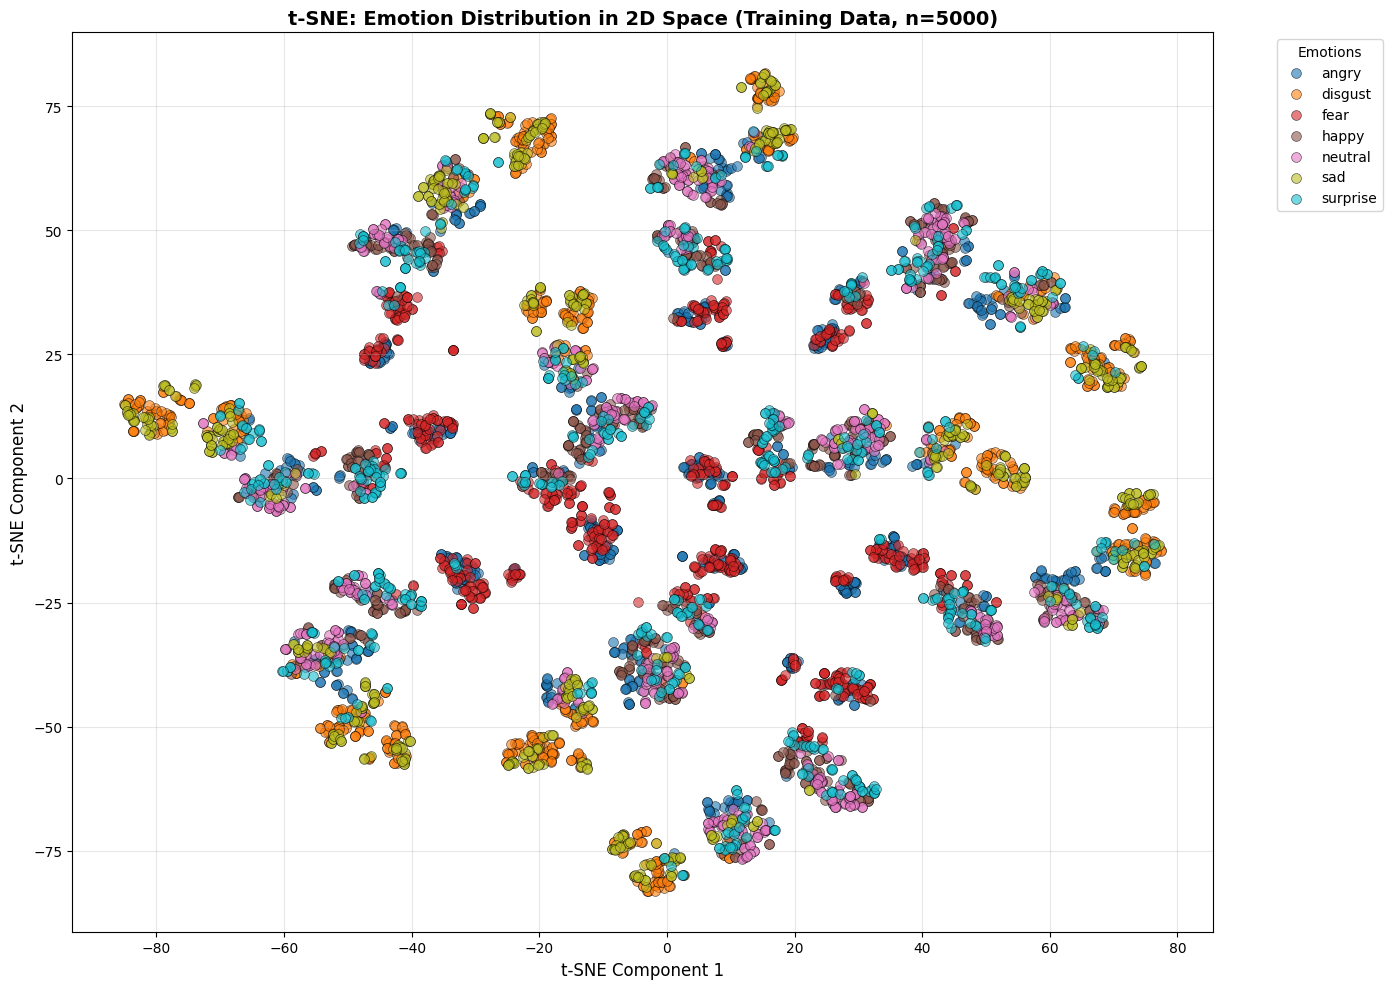

In [60]:
# Apply t-SNE to training data
from sklearn.manifold import TSNE
import time

print("Running t-SNE on training data (this may take a few minutes)...")
start_time = time.time()

# Use a subset for faster computation if dataset is very large
# For full dataset, remove the slicing
n_samples = min(5000, X_train.shape[0])  # Limit to 5000 samples for speed
X_train_subset = X_train[:n_samples]
y_train_subset = y_train[:n_samples]

tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    max_iter=1000,  # Changed from n_iter to max_iter for newer scikit-learn
    verbose=1
)

X_train_tsne = tsne.fit_transform(X_train_subset)

elapsed_time = time.time() - start_time
print(f"\nt-SNE completed in {elapsed_time:.2f} seconds")

# Get emotion labels
y_train_labels_subset = np.argmax(y_train_subset, axis=1)

# Create scatter plot
plt.figure(figsize=(14, 10))

for i, emotion in enumerate(emotion_names):
    mask = y_train_labels_subset == i
    plt.scatter(X_train_tsne[mask, 0], X_train_tsne[mask, 1], 
                c=[colors[i]], label=emotion, alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title(f't-SNE: Emotion Distribution in 2D Space (Training Data, n={n_samples})', fontsize=14, fontweight='bold')
plt.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Comparing different perplexity values for t-SNE...

Running t-SNE with perplexity=5...

Running t-SNE with perplexity=30...

Running t-SNE with perplexity=30...

Running t-SNE with perplexity=50...

Running t-SNE with perplexity=50...


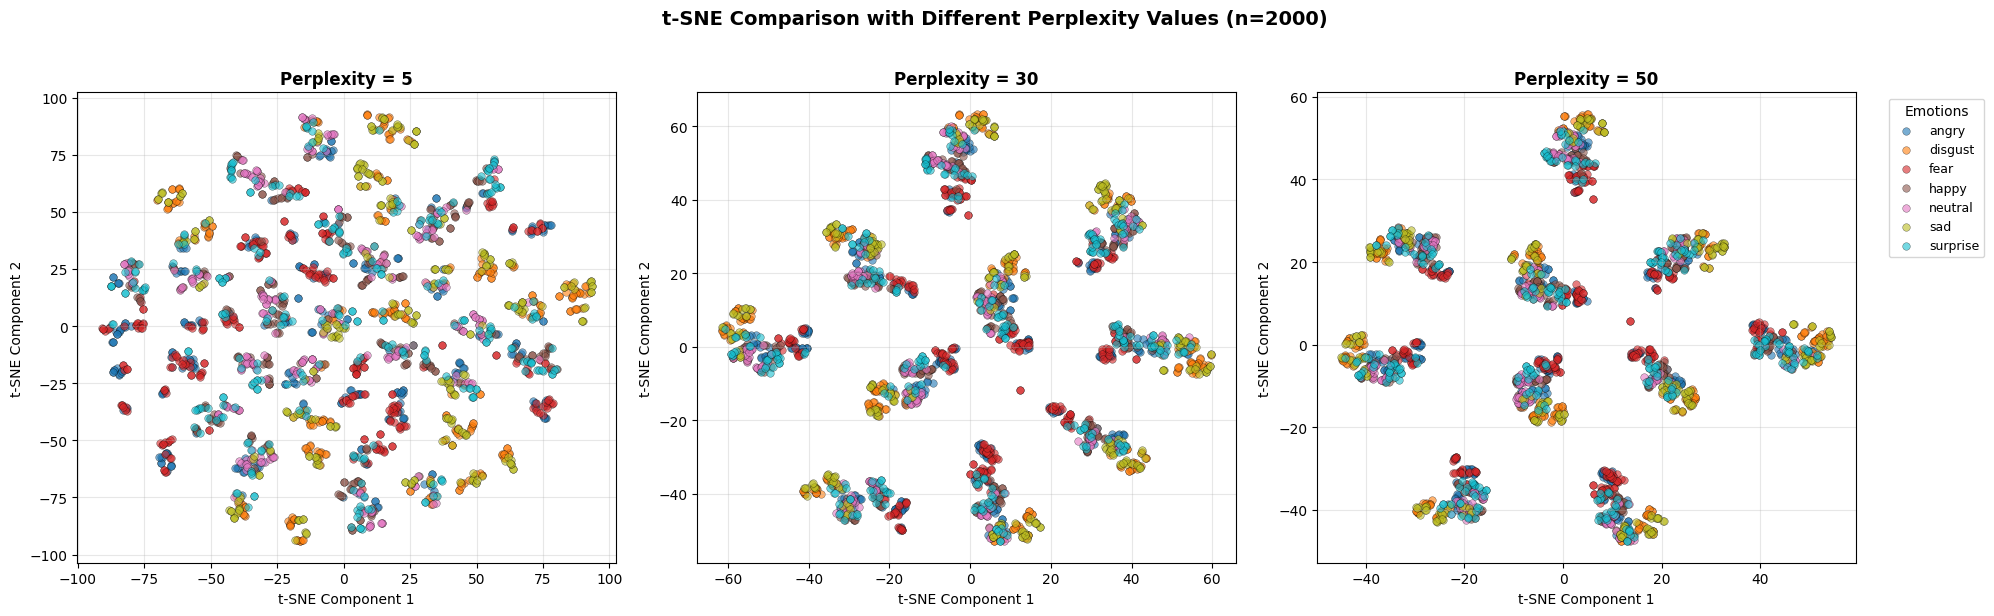


Perplexity interpretation:
- Low perplexity (5-10): focuses on very local structure
- Medium perplexity (30-50): balanced view (default is 30)
- High perplexity (50-100): focuses on global structure


In [61]:
# Compare different perplexity values for t-SNE
print("Comparing different perplexity values for t-SNE...")

perplexity_values = [5, 30, 50]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Use smaller subset for faster comparison
n_samples_comparison = min(2000, X_train.shape[0])
X_train_small = X_train[:n_samples_comparison]
y_train_small = y_train[:n_samples_comparison]
y_train_labels_small = np.argmax(y_train_small, axis=1)

for idx, perplexity in enumerate(perplexity_values):
    print(f"\nRunning t-SNE with perplexity={perplexity}...")
    
    tsne_temp = TSNE(
        n_components=2,
        random_state=42,
        perplexity=perplexity,
        max_iter=1000,  # Changed from n_iter to max_iter for newer scikit-learn
        verbose=0
    )
    
    X_tsne_temp = tsne_temp.fit_transform(X_train_small)
    
    ax = axes[idx]
    for i, emotion in enumerate(emotion_names):
        mask = y_train_labels_small == i
        ax.scatter(X_tsne_temp[mask, 0], X_tsne_temp[mask, 1], 
                  c=[colors[i]], label=emotion, alpha=0.6, s=30, edgecolors='k', linewidth=0.3)
    
    ax.set_xlabel('t-SNE Component 1', fontsize=10)
    ax.set_ylabel('t-SNE Component 2', fontsize=10)
    ax.set_title(f'Perplexity = {perplexity}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    if idx == 2:
        ax.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.suptitle(f't-SNE Comparison with Different Perplexity Values (n={n_samples_comparison})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nPerplexity interpretation:")
print("- Low perplexity (5-10): focuses on very local structure")
print("- Medium perplexity (30-50): balanced view (default is 30)")
print("- High perplexity (50-100): focuses on global structure")

In [39]:
import numpy as np

# Save the array
np.save('x_train.npy', x_train)

In [40]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8960, 2266), (8960, 7), (2240, 2266), (2240, 7))

In [25]:
# Reshape the data for Conv1D (CNN) input
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)

In [26]:
# Define the CNN model
model = tf.keras.Sequential([
    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_traincnn.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=5, strides=2, padding='same'),

    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPooling1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.2),

    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.BatchNormalization(),
    L.Dense(7, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762186604.846623      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [27]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Callbacks
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [29]:
# Train the model
history = model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test),
                    batch_size=64, callbacks=[model_checkpoint, early_stop, lr_reduction])

Epoch 1/50


I0000 00:00:1762186621.003752     167 service.cc:148] XLA service 0x7e3200002270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762186621.004633     167 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762186621.643510     167 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/609 ━━━━━━━━━━━━━━━━━━━━ 2:44:11 16s/step - accuracy: 0.1406 - loss: 2.5976

I0000 00:00:1762186631.082767     167 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


609/609 ━━━━━━━━━━━━━━━━━━━━ 108s 150ms/step - accuracy: 0.4060 - loss: 1.6395 - val_accuracy: 0.3893 - val_loss: 1.6420 - learning_rate: 0.0010
Epoch 2/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.5549 - loss: 1.1504 - val_accuracy: 0.5266 - val_loss: 1.2331 - learning_rate: 0.0010
Epoch 3/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.6067 - loss: 1.0171 - val_accuracy: 0.5928 - val_loss: 1.0527 - learning_rate: 0.0010
Epoch 4/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.6461 - loss: 0.9227 - val_accuracy: 0.6173 - val_loss: 1.0207 - learning_rate: 0.0010
Epoch 5/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.7028 - loss: 0.7834 - val_accuracy: 0.6390 - val_loss: 0.9519 - learning_rate: 0.0010
Epoch 6/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.7499 - loss: 0.6700 - val_accuracy: 0.6968 - val_loss: 0.8103 - learning_rate: 0.0010
Epoch 7/50
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - accuracy: 0.8066 - loss

In [30]:
# Save the entire model to HDF5
model.save('emotion_recognition_model.h5')

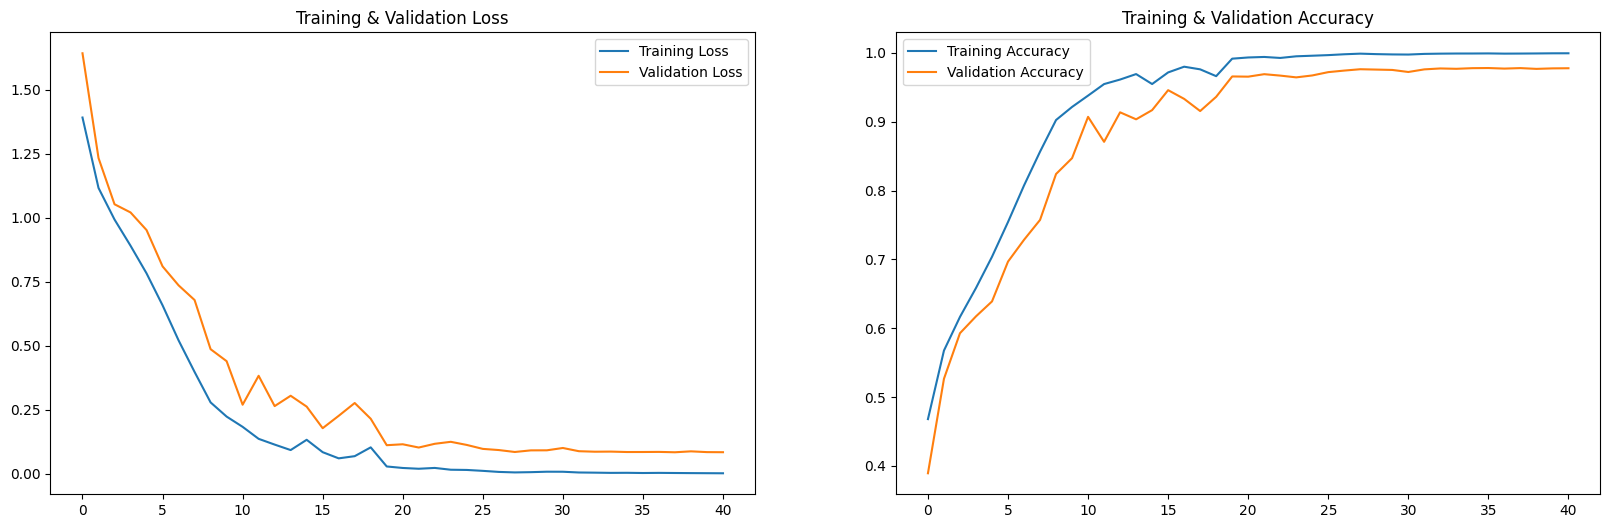

In [31]:
# Plot training history
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import classification_report

# Evaluate on test data
test_loss, test_acc = model.evaluate(x_testcnn, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
# Predict on the test set
y_pred = model.predict(x_testcnn)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=encoder.categories_[0])
print(report)

305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9780 - loss: 0.0835
Test Accuracy: 97.80%
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
              precision    recall  f1-score   support

       angry       0.98      0.98      0.98      1484
     disgust       0.98      0.97      0.97      1558
        fear       0.98      0.98      0.98      1505
       happy       0.97      0.97      0.97      1619
     neutral       0.98      0.98      0.98      1558
         sad       0.98      0.99      0.99      1478
    surprise       0.98      0.98      0.98       528

    accuracy                           0.98      9730
   macro avg       0.98      0.98      0.98      9730
weighted avg       0.98      0.98      0.98      9730

